# Experiments on EMG analysis
This notebook allows a researcher to collect data on a set of EMG. The data are collected for each breath and include total area under breath curve, maximum value in each breath, legnth of breaths, and relative location of maximum value(as both raw and percentage of total breath).

## Import libraries

In [79]:
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
import collections
from collections import namedtuple
import builtins
import math

In [80]:
import sys
sys.path.insert(0, '../resurfemg')
from config import Config

In [81]:
# get new changes in our library i.e. the tmsisdk

sys.path.insert(0, '../resurfemg')

from tmsisdk_lite import Poly5Reader

In [82]:

sys.path.insert(0, '../resurfemg')
import helper_functions as hf

# Set a collection place for experiments

In [83]:
# do not rerun this cell
big_data_list = []

Below change the path to the root directory where you are keeping your EMGs and ventilator "Draeger" files

# Reruns should be done from this cell as the start

In [84]:
config = Config()
root_emg_directory = config.get_directory('root_emg_directory')

In [85]:
emg_pattern = os.path.join(root_emg_directory, '**/*.Poly5')
emg_and_draeger_files = glob.glob(emg_pattern, recursive=True)

emg_files = []
draeger_files = []

for file in emg_and_draeger_files:
    if 'Draeger' in file:
        draeger_files.append(file)
    else:
        emg_files.append(file)

Now you can pick a file from the list, which have been numbered.

In [86]:
list_of_numbers_strung = []
for i in range(len(emg_files)):
    list_of_numbers_strung.append(str(i))


btn = widgets.Dropdown(
    options=list_of_numbers_strung,
    value='0',
    description='Picked File:',
    disabled=False,
)
display(btn)

Dropdown(description='Picked File:', options=('0', '1', '2', '3', '4', '5', '6', '7', '8'), value='0')

# Caution! 
If you folder is set up in any way different then the picked file numbers will not neccesarily correspond to the same file. Always check the print out for the file you have chosen in the cell below

In [87]:
number_chosen = int(btn.value)
file_chosen = emg_files[number_chosen] 
print("The file you chose is:",file_chosen)

The file you chose is: C:/Users/OppersmaE/surfdrive/Shared/TOPSPIN_anonymous_data/M001\001\EMG_recording.Poly5


In [88]:
data_emg = Poly5Reader(file_chosen)
data_samples= data_emg.samples
emg_sample_rate = data_emg.sample_rate
converted_to_seconds =  []
converted_to_samples = []
for i in range(len(data_samples[0])):
    converted_to_seconds.append(i/emg_sample_rate)
    converted_to_samples.append(i)

Reading file  C:/Users/OppersmaE/surfdrive/Shared/TOPSPIN_anonymous_data/M001\001\EMG_recording.Poly5
	 Number of samples:  172576 
	 Number of channels:  3 
	 Sample rate: 2048 Hz
Done reading data.


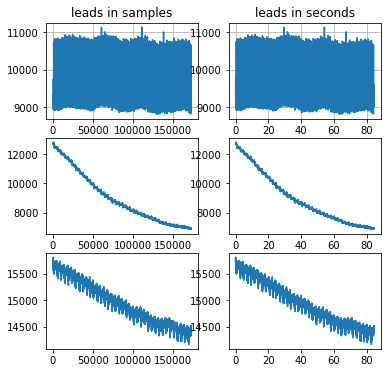

In [89]:
%matplotlib inline
# set up plotn
x = data_samples
fig, axis = plt.subplots(nrows = 3, ncols = 2, figsize=(6, 6))
axis[0,0].grid(True)
axis[0,0].plot(x[0])
axis[0,0].set(title='leads in samples')
axis[1,0].plot(x[1])
axis[2,0].plot(x[2])
axis[0,1].set(title='leads in seconds')
axis[0,1].grid(True)
axis[0,1].plot(converted_to_seconds,x[0])
axis[1,1].plot(converted_to_seconds,x[1])
axis[2,1].plot(converted_to_seconds,x[2])

That is the whole unfiltered EMG, but you probably want to examine a part. You will also want to examine something filtered down to only the EMG components. Therefore we will filter off only the EMG components with an ICA in addtion to the filter we will play with.

Now you can filter down to which part you want to see. 

Do you want to cut and see the file in samples or seconds?

In [90]:
y_axis = widgets.Dropdown(
    options=["Samples","Seconds"],
    value='Samples',
    description="Select View Option",
    disabled=False,
)
display(y_axis)


Dropdown(description='Select View Option', options=('Samples', 'Seconds'), value='Samples')

In [91]:
time_view= y_axis.value
time_view

'Samples'

Now you will pick the start and end of your sample.We are going to clip the end of the sample in processing, so you can not pick any values and get a good graph. We preset the values towards the max graphable with ease, but they can be overwritten.  In the future we will have an updating graph here. 

In [92]:
if time_view == 'Samples':
    int_slider1 = widgets.IntSlider(
        min=0, max=int(len(x[0])*0.89), step=1,
        description=' samples start'
    )
    int_slider2 = widgets.IntSlider(
        value=len(x[0]),
        min=0, max=int(len(x[0])*0.89), step=1,
        description='samples end cutoff'
    )
else:
    int_slider1 = widgets.IntSlider(
        #value=0.1,
        min=0, max= int(converted_to_seconds[-1])*0.89, step=1,
        description='seconds start'
    )
    int_slider2 = widgets.IntSlider(
        #value=converted_to_seconds[-1],
        min=0, max=int(converted_to_seconds[-1])*0.89, step= 1,
        description='seconds end cutoff'
    )
    
widgets.VBox(
    [

        int_slider1,
        int_slider2,

    ]
)



You can overwrite the values by hand in the next cell, if scrolling is not precise enough...but rewriting to take an absolute end is unadvisable.

In [93]:
# # # # Here we can overwrite the values by hand, again you must pick values a bit inside
# int_slider1.value = 1
# int_slider2.value = 17

For now we will graph your choice in the next active cell

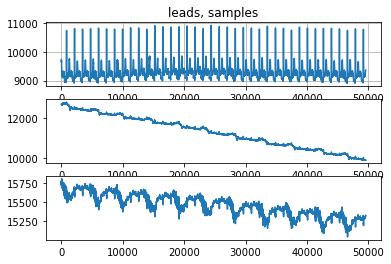

In [134]:
start = int_slider1.value
end= int_slider2.value
if time_view == 'Samples':
    # nox examine at a certain scale- from point a to b as samples
    x = data_samples
    fig, (ax_1,ax_2,ax_3) = plt.subplots(nrows = 3, figsize=(6, 4))
    ax_1.grid(True)
    ax_1.plot(x[0][int(start):int(end)])
    ax_1.set(title='leads, samples')
    ax_2.plot(x[1][int(start):int(end)])
    ax_3.plot(x[2][int(start):int(end)])
    
if time_view == 'Seconds':
    # nox examine at a certain scale- from point a to b as samples
    x_for_secs = data_samples

    y = converted_to_seconds
    fig, (ax_1,ax_2,ax_3) = plt.subplots(nrows = 3, figsize=(6, 4))
    ax_1.grid(True)
    ax_1.plot(y[int(start*emg_sample_rate):int(end*emg_sample_rate)],x[0][int(start*emg_sample_rate):int(end*emg_sample_rate)])
    ax_1.set(title='leads, seconds')
    ax_2.plot(y[int(start*emg_sample_rate):int(end*emg_sample_rate)],x[1][int(start*emg_sample_rate):int(end*emg_sample_rate)])
    ax_3.plot(y[int(start*emg_sample_rate):int(end*emg_sample_rate)],x[2][int(start*emg_sample_rate):int(end*emg_sample_rate)])
    

Happy with your selection? If not redo the widgeted cell, then we can see how the filter the selection in a basic pipleline before extracting entropy.

In [135]:
def minimal_ecg_pipeline(our_chosen_file, heart_lead_number, frequency):
    """
    Here we have a minimal basic pre-processing pipeline. Note 
    heart leads should be counted in Python numbering
    i.e. lead number one is zero. 
    """
# step 1 cut off any wierd end
    cut_file_data = hf.bad_end_cutter_for_samples(
        our_chosen_file, percent_to_cut=3, tolerance_percent=5)
    # step 2 minimal filtering    
    bd_filtered_file_data = hf.emg_bandpass_butter_sample(
        cut_file_data, 1, frequency/2.1, frequency, output='sos')
    # step 3 end-cutting again to get rid of filtering artifacts
    re_cut_file_data = hf.bad_end_cutter_for_samples(
        bd_filtered_file_data, percent_to_cut=3, tolerance_percent=5)
    return re_cut_file_data

In [136]:
processed_data_emg2 = minimal_ecg_pipeline(data_samples,0, 2048)[2]


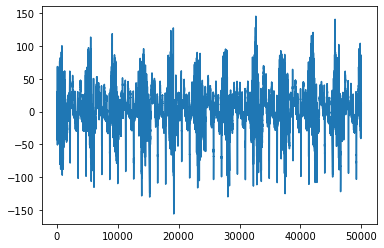

In [137]:
plt.plot(processed_data_emg2[0:50000])

In [138]:
# dropdown to pick ICA possibilities. CUrrently only one -\o/-
ICA_choice = widgets.Dropdown(
    options=["classic","no_ica_lead3"],
    value='classic',
    description="Select View Option",
    disabled=False,
)
display(ICA_choice)

Dropdown(description='Select View Option', options=('classic', 'no_ica_lead3'), value='classic')

Here we will have to rewrite to accomodate different ICAs, but this is in the future. After we iron out the alternative ICAs. Below we put our EMG data through the pipeline we have now, and we must do picking from an ICA by more peaks or by dis-similarity to the heart/ECG lead.

In [139]:
ICA_picker_choice = widgets.Dropdown(
    options=["more_peaks","similar_to_ECG"],
    value='more_peaks',
    description="Select View Option",
    disabled=False,
)
display(ICA_picker_choice)

Dropdown(description='Select View Option', options=('more_peaks', 'similar_to_ECG'), value='more_peaks')

In [140]:
ICA_picker_choice.value

'more_peaks'

# Let's examine our processed EMG

C:\Users\OppersmaE\Anaconda3\envs\emgandash\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning:

From version 1.3 whiten='unit-variance' will be used by default.



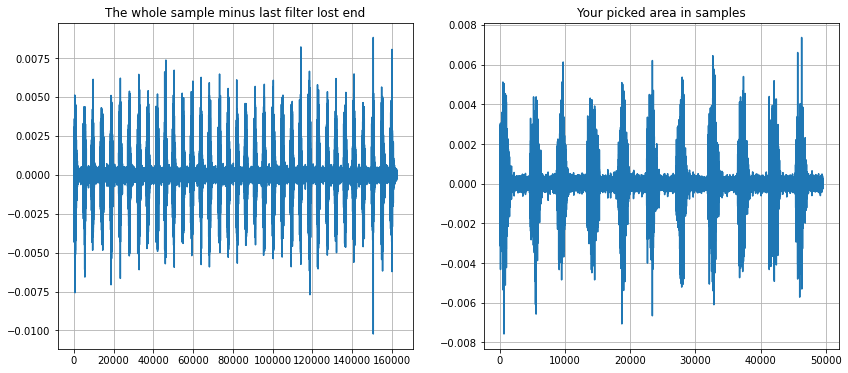

In [141]:
if ICA_picker_choice.value == 'more_peaks':
    processed_data_emg = hf.working_pipeline_pre_ml(data_samples,picker='peaks')
elif ICA_picker_choice.value == 'similar_to_ECG':
    processed_data_emg = hf.working_pipeline_pre_ml(data_samples,picker='heart')
else:
    processed_data_emg = hf.working_pipeline_pre_ml(data_samples,picker='heart')

if time_view == 'Seconds':
    %matplotlib inline
    # set up plotn
    x = processed_data_emg
    fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize=(14, 6))
    axis[0].grid(True)
    axis[0].plot(converted_to_seconds[:len(x)], x)
    axis[0].set(title='The whole sample minus last filter lost end')
    axis[1].set(title='Your picked area in seconds')
    axis[1].grid(True)
    axis[1].plot(converted_to_seconds[int(start*emg_sample_rate):int(end*emg_sample_rate)],x[int(start*emg_sample_rate):int(end*emg_sample_rate)])
else:
    %matplotlib inline
    x = processed_data_emg
    fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize=(14, 6))
    axis[0].grid(True)
    axis[0].plot(x)
    axis[0].set(title='The whole sample minus last filter lost end')
    axis[1].set(title='Your picked area in samples')
    axis[1].grid(True)
    axis[1].plot(converted_to_samples[int(start):int(end)],x[int(start):int(end)])
    

Now we created some basic processed EMG. Now we need to determine where the breaths are. We will graph the results to make sure we are happy with the. The cutoff forsample selected will be based on entropy here. You ultimately do a cut-off based on something popular in the literature, or your own ideas. 


In [102]:
# in case we want to look in seconds later
start_s= start * emg_sample_rate
end_s = end * emg_sample_rate


In the above picture the green line represents a 0,1, array which represents the breaths. That picking was based on one simple parameter.

We will do picking of breaths based on identifying places in teh signal with 90%  or more of max entropy, then including from there places with  50% or more this will give start of breath with smoothing of the array if there is too short a pause. This is a more complicated algorithm than an arbitrary baseline, but gives good results. 

In [103]:
# reminder
time_view

'Samples'

In [104]:
#ICA
type(processed_data_emg)
processed_data_emg.shape

(162376,)

In [105]:
#nonICA
type(processed_data_emg2)
processed_data_emg2.shape

(162376,)

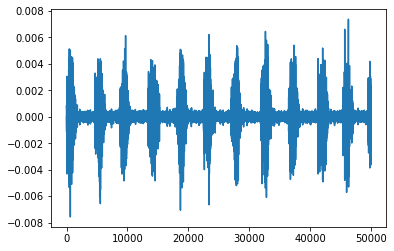

In [106]:
plt.plot(processed_data_emg[0:50000])

162376

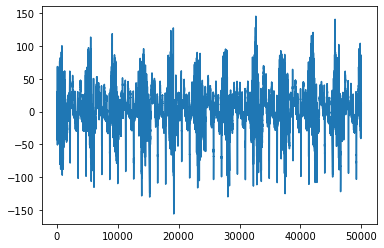

In [107]:
plt.plot(processed_data_emg2[0:50000])
len(processed_data_emg2)

Variability on ECG - EMG

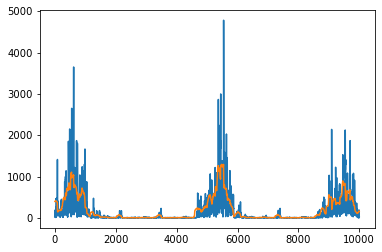

In [143]:
vars_emg2=[]
for i in range(1, len(processed_data_emg2)-10):
    var_emg = np.var(processed_data_emg2[i:i + 10])
    vars_emg2.append(var_emg)

rms_rolled2 = hf.vect_naive_rolling_rms(vars_emg2,100) # so rms is rms entropy
plt.plot(vars_emg2[0:10000])
plt.plot(rms_rolled2[0:10000])


Variability on ICA EMG

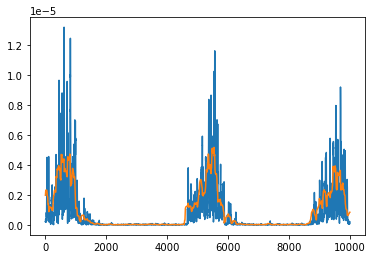

In [144]:
vars_emg=[]
for i in range(1, len(processed_data_emg)-10):
    var_emg = np.var(processed_data_emg[i:i + 10])
    vars_emg.append(var_emg)

rms_rolled = hf.vect_naive_rolling_rms(vars_emg,100) # so rms is rms entropy
plt.plot(vars_emg[0:10000])
plt.plot(rms_rolled[0:10000])


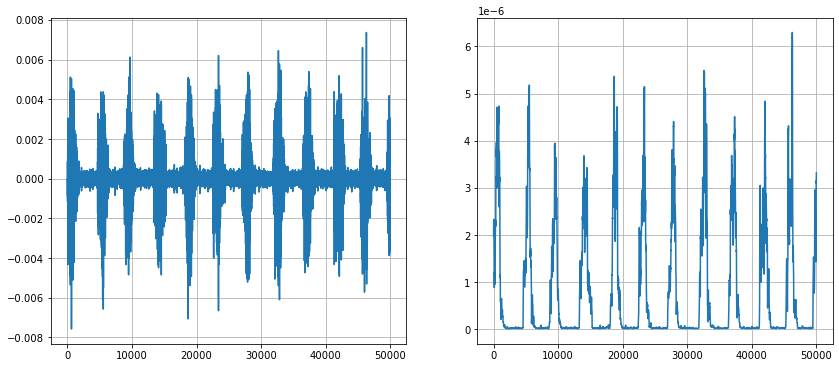

In [167]:
%matplotlib inline
x = processed_data_emg
fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize=(14, 6))
axis[0].grid(True)
axis[0].plot(x[0:50000])
#axis[0].set(title='The whole sample minus last filter lost end')
#axis[1].set(title='Your picked area in samples')
axis[1].grid(True)
axis[1].plot(rms_rolled[0:50000])

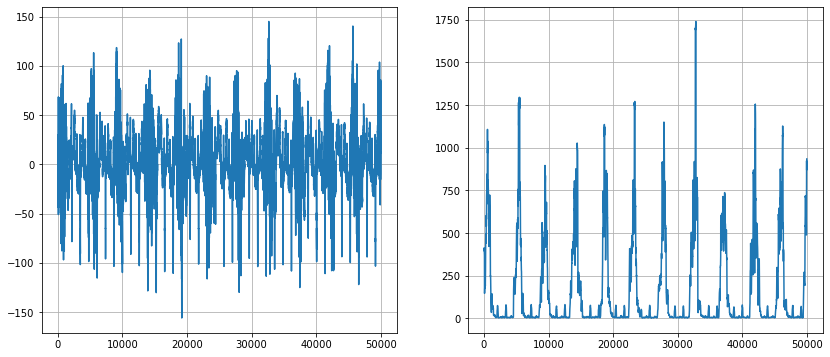

In [146]:
%matplotlib inline
x = processed_data_emg2
fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize=(14, 6))
axis[0].grid(True)
axis[0].plot(x[0:50000])
#axis[0].set(title='The whole sample minus last filter lost end')
#axis[1].set(title='Your picked area in samples')
axis[1].grid(True)
axis[1].plot(rms_rolled2[0:50000])

6.503417019852406e-09
1.9913840179833845e-06


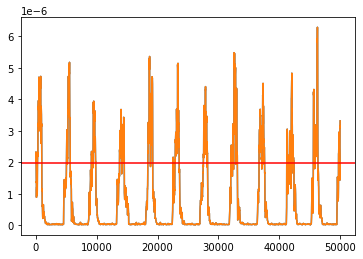

In [169]:
#high_decision_cutoff = 0.9  * ((np.max(rms_rolled)) - (np.min(rms_rolled))) + np.min(rms_rolled)
#decision_cutoff = 0.05 * ((np.max(rms_rolled)) - (np.min(rms_rolled))) + np.min(rms_rolled)

mean_decision_cutoff =( np.mean(rms_rolled) + np.std(rms_rolled) )

plt.plot(rms_rolled[0:50000])
plt.plot(rms_rolled[0:50000])
plt.axhline(y =  mean_decision_cutoff, color = 'r', linestyle = '-')
#plt.axhline(y =  high_decision_cutoff, color = 'purple', linestyle = '-')
#plt.axhline(y =  decision_cutoff, color = 'green', linestyle = '-')


#plt.plot(rmn[0:50000])
print(np.min(rms_rolled))
print(mean_decision_cutoff)

New approach: detect peaks in variability rms signal. Create a loop, for each peak, to go from the peak, down to the min of the var signal on both sides of the peak. In case of 2 detected peak without a minimum in between, the lowest peak should be discarded. 

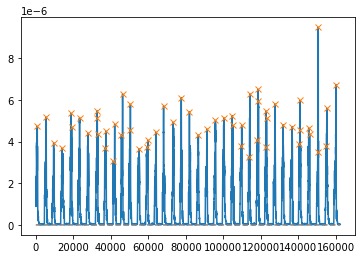

(56,)

In [176]:
rms_rolled_test=rms_rolled[10000:63000]
peaks, _ = find_peaks(rms_rolled, height=np.mean(rms_rolled), distance=150, prominence=0.2*np.max(rms_rolled))

plt.plot(rms_rolled)
plt.plot(peaks, rms_rolled[peaks], "x")
plt.plot(np.zeros_like(rms_rolled), "--", color="gray")

plt.show()
peaks.shape

In [189]:
prev_min=[]
post_min=[]
cutoff=np.mean(rms_rolled)*1.5
for index in range(1, len(peaks)-1):
    wdw=rms_rolled[peaks[index-1]:peaks[index]]
    index_cutoff=np.where(wdw<cutoff)
    if index_cutoff[0].size!=0:
        prev_min.append(np.max(index_cutoff[0])+peaks[index-1])

for index in range(1, len(peaks)-1):
    wdw=rms_rolled[peaks[index]:peaks[index+1]]
    index_cutoff=np.where(wdw<cutoff)
    if index_cutoff[0].size!=0:
        post_min.append(np.min(index_cutoff[0])+peaks[index])
    
print(prev_min)
print(post_min)
print(np.min(rms_rolled))

[4837, 9097, 13576, 18328, 22800, 27383, 32025, 36619, 41217, 41426, 45535, 49714, 54544, 58929, 63525, 67732, 72728, 77151, 81611, 86038, 90382, 95026, 99563, 104536, 108929, 113344, 117774, 122274, 126907, 131139, 135632, 140280, 145066, 150048, 154476]
[5838, 9867, 14538, 19222, 23644, 28256, 33116, 37623, 41391, 42414, 46474, 50588, 55391, 59833, 64269, 68752, 73750, 78070, 82547, 86947, 91491, 96017, 100751, 105283, 109970, 114297, 118829, 123265, 127780, 132245, 136849, 141298, 146114, 150819, 155563]
6.503417019852406e-09


In [190]:
bin_detect=np.zeros((len(rms_rolled),),dtype=int)
for item in range(0,len(prev_min)):
    post_min_index=np.where(post_min>prev_min[item])
    if post_min_index[0].size!=0:
        bin_detect[prev_min[item]:post_min[post_min_index[0][0]]]=100
len(bin_detect)

162265

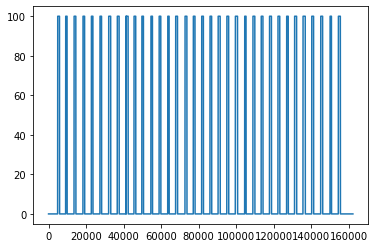

In [191]:
plt.plot(bin_detect)

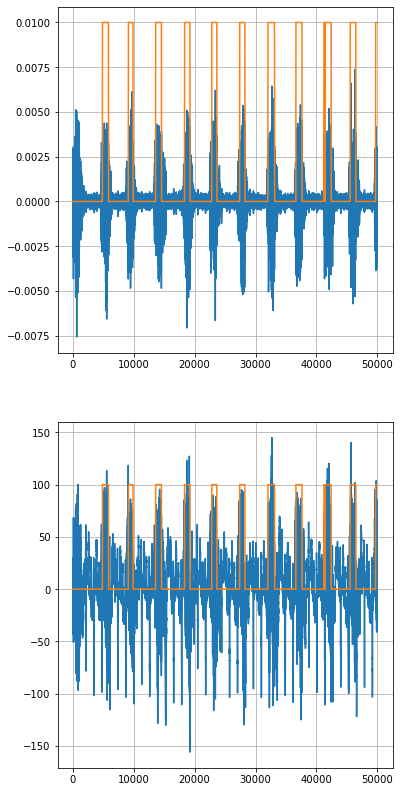

In [192]:
fig, axis = plt.subplots(nrows = 2, ncols = 1, figsize=(6, 14))
axis[0].grid(True)
axis[0].plot(processed_data_emg[0:50000])
axis[0].plot(bin_detect[0:50000]/10000)
#axis[0].set(title='The whole sample minus last filter lost end')
#axis[1].set(title='Your picked area in samples')
axis[1].grid(True)
axis[1].plot(processed_data_emg2[0:50000])
axis[1].plot(bin_detect[0:50000])


In [193]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure(go.Scatter(name="Current processing", opacity=0.5, line=dict(color='blue',)), y = processed_data_emg)
fig.add_trace(go.Scatter(name="Current processing", opacity=0.5, line=dict(color='blue',)), y = processed_data_emg2)

fig.show()

TypeError: invalid Figure property: y
y
Bad property path:
y
^

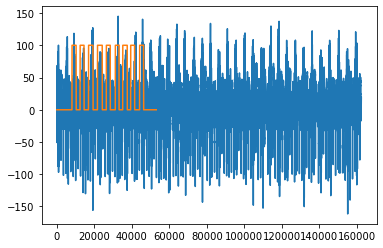

In [48]:
plotly.(processed_data_emg2)
plt.plot(bin_detect)

In [43]:
len(prev_min)
len(post_min)

10

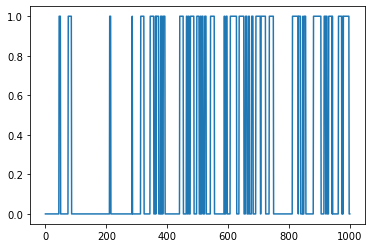

In [44]:
#hi = np.array(hf.zero_one_for_jumps_base(vars_emg, high_decision_cutoff))
#lo = np.array(hf.zero_one_for_jumps_base(vars_emg, decision_cutoff))
mn = np.array(hf.zero_one_for_jumps_base(vars_emg, mean_decision_cutoff))
plt.plot(mn[0:1000])


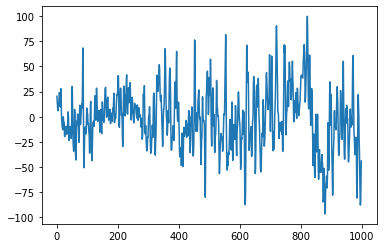

In [45]:
plt.plot(processed_data_emg2[0:1000])


In [46]:
#hi = np.array(hf.zero_one_for_jumps_base(vars_emg, high_decision_cutoff))
#lo = np.array(hf.zero_one_for_jumps_base(vars_emg, decision_cutoff))
mn = np.array(hf.zero_one_for_jumps_base(vars_emg, mean_decision_cutoff))

#rhi = hf.ranges_of(hi)
#rlo = hf.ranges_of(lo)
rmn = hf.ranges_of(mn)

keep = hf.intersections(rlo, rhi)


points = np.array(sum(keep, start=()), dtype=np.int32)

seven_line = np.zeros(len(vars_emg))
for seven_range in keep:
    seven_line[seven_range.to_slice()] = 50
plt.plot(processed_data_emg2[0:500], alpha = 0.5)
plt.plot(hf.zero_one_for_jumps_base(vars_emg,decision_cutoff)[0:500],  color = 'green')
#plt.plot(np.array(hf.zero_one_for_jumps_base(vars_emg,high_decision_cutoff)))*2, color= 'purple')
plt.plot(seven_line[0:500])


NameError: name 'rlo' is not defined

In [ ]:
#### plt.plot(hf.zero_one_for_jumps_base(vars_emg,decision_cutoff)[0:50000])


In [ ]:
from scipy.stats import entropy
def rounded_for_ent(stralist):
    rounded= np.round_(stralist, decimals = 5)
    return rounded
if time_view == 'Samples':
    big_list = rounded_for_ent(processed_data_emg[int(start):int(end)])# replace with whole array of time series!
else:
    big_list = rounded_for_ent(processed_data_emg[int(start_s):int(end_s)])
slice_length = 100
def sliceIterator(lst, sliceLen):
    for i in range(len(lst) - sliceLen + 1):
        yield lst[i:i + sliceLen]
index_hold = []
for slice in sliceIterator(big_list, slice_length):
    entropy_index = entropy(slice)
    index_hold.append(entropy_index)

high_decision_cutoff = 0.9  * ((np.max(index_hold)) - (np.min(index_hold))) + np.min(index_hold)
decision_cutoff = 0.5 * ((np.max(index_hold)) - (np.min(index_hold))) + np.min(index_hold)

rms_rolled = hf.vect_naive_rolling_rms(index_hold,100) # so rms is rms entropy


if time_view == 'Samples':
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],processed_data_emg[int(start):(int(start) + len(rms_rolled))]*1000, alpha = 0.5)
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],rms_rolled)
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],hf.zero_one_for_jumps_base(rms_rolled,decision_cutoff))
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],hf.zero_one_for_jumps_base(rms_rolled,high_decision_cutoff), color= 'purple')
    plt.axhline(y = decision_cutoff, color = 'r', linestyle = '-')
    plt.axhline(y = high_decision_cutoff, color = 'purple', linestyle = '-')
    
else:
    y = converted_to_seconds
    plt.plot(converted_to_seconds[int(start_s):(int(start_s)+int(len(rms_rolled)))], processed_data_emg[int(start_s):(int(start_s)+len(rms_rolled))]*1000, alpha = 0.5)
    plt.plot(converted_to_seconds[int(start_s):(int(start_s)+int(len(rms_rolled)))],rms_rolled)
    plt.plot(converted_to_seconds[int(start_s):(int(start_s)+int(len(rms_rolled)))],hf.zero_one_for_jumps_base(rms_rolled,decision_cutoff))
    plt.plot(converted_to_seconds[int(start_s):(int(start_s)+int(len(rms_rolled)))],hf.zero_one_for_jumps_base(rms_rolled,high_decision_cutoff), color = 'purple')
    plt.axhline(y = decision_cutoff, color = 'r', linestyle = '-')
    plt.axhline(y = high_decision_cutoff, color = 'purple', linestyle = '-')
    

In [ ]:
hi = np.array(hf.zero_one_for_jumps_base(rms_rolled, high_decision_cutoff))
lo = np.array(hf.zero_one_for_jumps_base(rms_rolled, decision_cutoff))

rhi = hf.ranges_of(hi)
rlo = hf.ranges_of(lo)

keep = hf.intersections(rlo, rhi)


points = np.array(sum(keep, start=()), dtype=np.int32)
points

In [ ]:
#plt.plot(entropy_index)
entropy_index.shape
entropy(big_list[0:1000])


In [ ]:
seven_line = np.zeros(len(rms_rolled))
for seven_range in keep:
    seven_line[seven_range.to_slice()] = 7
if time_view == 'Samples':
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],processed_data_emg[int(start):(int(start) + len(rms_rolled))]*1000, alpha = 0.5)
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],hf.zero_one_for_jumps_base(rms_rolled,decision_cutoff),  color = 'green')
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],(np.array(hf.zero_one_for_jumps_base(rms_rolled,high_decision_cutoff)))*2, color= 'purple')
    #plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))], six_line)
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))], seven_line)
else:
    plt.plot(converted_to_seconds[int(start_s):(int(start_s) + len(rms_rolled))],processed_data_emg[int(start_s):(int(start_s) + len(rms_rolled))]*1000, alpha = 0.5)
    plt.plot(converted_to_seconds[int(start_s):(int(start_s) + len(rms_rolled))],hf.zero_one_for_jumps_base(rms_rolled,decision_cutoff),  color = 'green')
    plt.plot(converted_to_seconds[int(start_s):(int(start_s) + len(rms_rolled))],(np.array(hf.zero_one_for_jumps_base(rms_rolled,high_decision_cutoff)))*2, color= 'purple')
    #plt.plot(converted_tosecondss[int(star_st):(int(star_st) + len(rms_rolled))], six_line)
    plt.plot(converted_to_seconds[int(start_s):(int(start_s) + len(rms_rolled))], seven_line)
    

So above our 'seven-line' represents picking based on finding areas with 90% max entropy, then picking evything around them with over 50% entropy.

## What happened in these breaths?

We want to know:
legnth of breaths,
relative location of maximum value inside the breath(as both raw and percentage of total breath),
the area under the curve for each breath- total area per breath,
then the area to where we cross back over 70% of peak values.


Now we need to figure out which elements of grouped are breath parts, and make arrays of just those.

In [ ]:
# so grouped needs to be picked down to where at jump indeces we go up from 0 to 7
our_emg_array_samples = processed_data_emg[int(start):(int(start) + len(rms_rolled))]
our_emg_array_seconds = processed_data_emg[int(start_s):(int(start_s) + len(rms_rolled))]
zippy = zip(seven_line,seven_line[1:])
breath_indeces = []
for val in enumerate(zippy):
    if val[1][0] < val[1][1]:
        print(val[0])
        breath_indeces.append(val[0])
if time_view == 'Samples':
    grouped_breaths = np.split(our_emg_array_samples, breath_indeces)
    grouped_entropy = np.split(rms_rolled, breath_indeces)
    grouped_breaths = grouped_breaths[1:]
    grouped_entropy = grouped_entropy[1:]

else:
    grouped_breaths = np.split(our_emg_array_seconds, breath_indeces)
    grouped_entropy= np.split(rms_rolled, breath_indeces)
    grouped_breaths = grouped_breaths[1:]
    grouped_entropy = grouped_entropy[1:]


How many breaths did we catch?

In [ ]:
len(grouped_breaths)

Let's look at them

In [ ]:
for group in grouped_breaths:
    group = abs(group)
    plt.plot(group, alpha = 0.5)

In [ ]:
for group in grouped_entropy:
     plt.plot(group, alpha = 0.5)

Great! We see we caught the breaths...notice they follow a typical pattern with entropy- we were counting on that!

In [ ]:
# optional cell to examine each breath by graphing it alone
group = abs(grouped_breaths[30])
plt.plot(group, alpha = 0.5)

## legnth of each breath

In [ ]:
lengths = []
samples = []
breath_number = list(range(len(grouped_breaths)))
for i in breath_number:
# for breath in grouped_breaths:
    lengths.append(len(grouped_breaths[i]))
    samples.append(i)
d1 = {'samples': samples, 'lengths': lengths}
df1 = pd.DataFrame(d1) 
df1

## Maxima for each breath
Note out  breaths contain positive and negative numbers...so we will make them positive

In [ ]:
maxima= []
samples = []
breath_number = list(range(len(grouped_breaths)))
for i in breath_number:
# for breath in grouped_breaths:
    point = hf.find_peak_in_breath(abs(grouped_breaths[i]), 0,len(grouped_breaths[i]))
    maxima.append(point)
    samples.append(i)


In [ ]:
# note we will get a tuple of (where, how high)
d2 = {'samples': samples, 'maxima': maxima}
#d2 = {'samples': samples, 'maxima_loc': maxima_loc, 'maxima': maxima_height}
df2 = pd.DataFrame(d2) 
df2

## Maxima location by percent
Obviously if we merge the dataframes we can add a column for maximal location by percent

In [ ]:
df_1and2 = df1.merge(df2, on='samples')
df_1and2 

In [ ]:
df_1and2['location_maxima'] = df_1and2.apply(lambda row: row['maxima'][0], axis=1)
df_1and2['height_maxima'] = df_1and2.apply(lambda row: row['maxima'][1], axis=1)
df_1and2['percent_forward_maxima'] = df_1and2['location_maxima'] /df_1and2['lengths']
df_1and2

## Area under curve
Note out breaths are both poositive and negative values, so we will use absolute values...and we will merge onto our larger datafame

In [ ]:
areas_70 = []
simple_areas = []
samples = []
breath_number = list(range(len(grouped_breaths)))
for i in breath_number:
# for breath in grouped_breaths:
    area_70 = hf.area_under_curve(
        abs(grouped_breaths[i]),
        0,
        (len(grouped_breaths[i])-1),
        end_curve=70,
        smooth_algorithm='mid_savgol',
    )
    simple_area = np.sum(abs(grouped_breaths[i]))
    areas_70.append(area_70)
    simple_areas.append(simple_area)
    samples.append(i)
d3 = {'samples': samples, 'areas_70': areas_70, 'simple_AUC' : simple_areas}
df3 = pd.DataFrame(d3) 
df123 = df_1and2.merge(df3, on = 'samples')
df123